# GoogLeNet
* Inception 모듈을 사용한다.
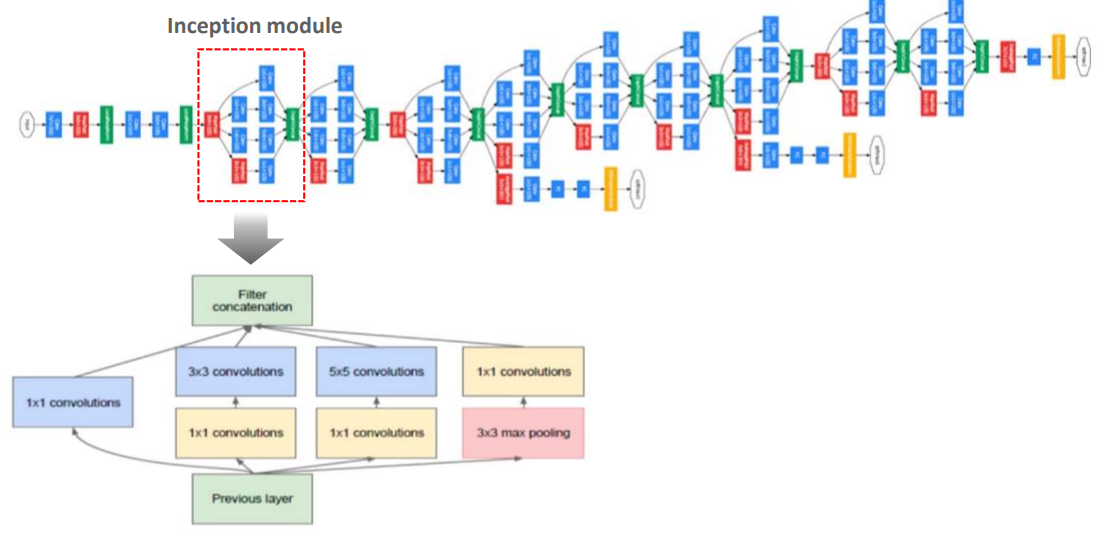

## Inception Module
다양한 사이즈의 필터를 이용해서 하나의 이미지를 보는 것
* Bottle Neck 구조라고도 할 수 있는 `(1x1)` Conv 연산을 통해 채널의 개수를 적절하게 조절하여 파라미터의 개수를 줄일 수가 있다.
* 이미지로부터 다양한 사이즈의 정보를 획득하고 **이어 붙인다**

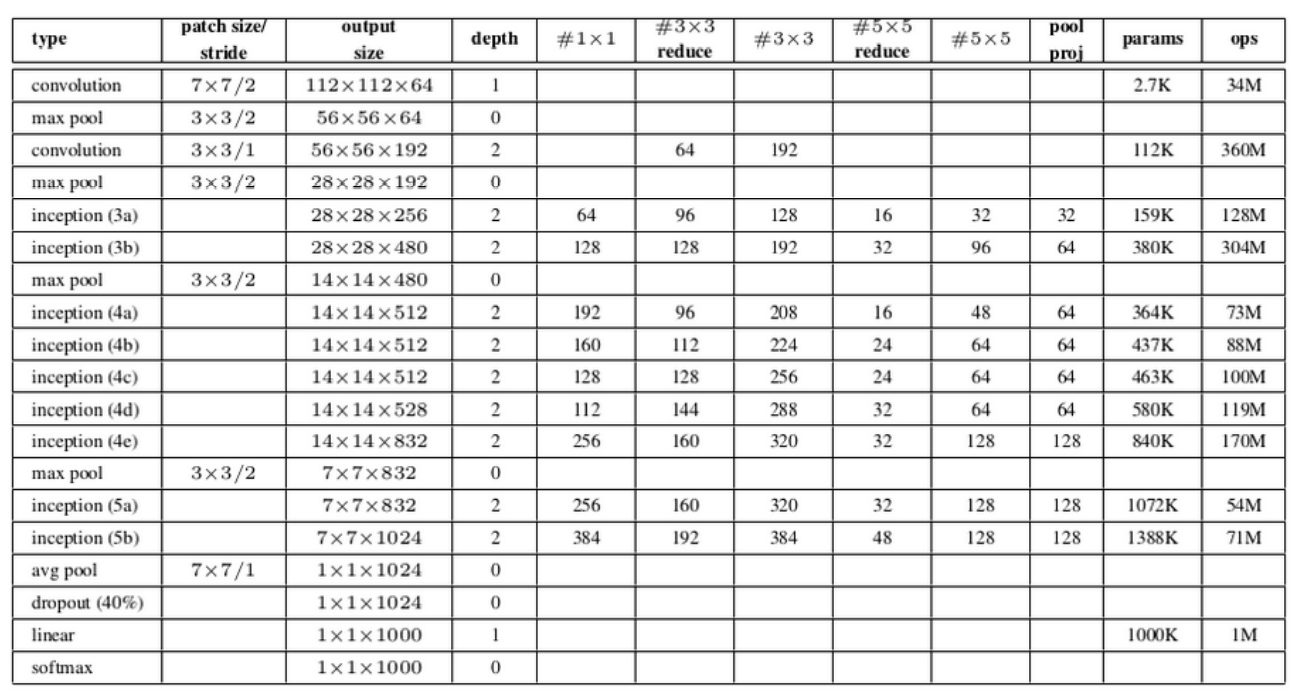

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate

# Inception Module( Inception Block ) 구현하가ㅣ
def inception_module(previous_x, # 이전 층의 결과 텐서
                     filters_1x1, # 1 x 1 Conv
                     filters_3x3_reduce, # 3x3 BottleNeck
                     filters_3x3, # 3x3 Conv
                     filters_5x5_reduce, # 5x5 BottleNeck
                     filters_5x5, # 5x5 Conv
                     filters_pool_proj, # Pooling BottleNeck
                     name
                     ):
  
  # 첫 번째 1x1 Conv
  conv_1x1 = Conv2D(filters=filters_1x1, kernel_size=(1, 1), activation='relu')(previous_x)
  
  # 두 번째 1x1 Conv (Reduce) -> 3x3 Conv
  conv_3x3_reduce = Conv2D(filters=filters_3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu')(previous_x)
  conv_3x3 = Conv2D(filters=filters_3x3, kernel_size=(3, 3), padding='same', activation='relu')(conv_3x3_reduce)

  # 세 번째 1x1 Conv (Reduce) -> 5x5 Conv
  conv_5x5_reduce = Conv2D(filters=filters_5x5_reduce, kernel_size=(1, 1), padding='same', activation='relu')(previous_x)
  conv_5x5 = Conv2D(filters=filters_5x5, kernel_size=(5, 5), padding='same', activation='relu')(conv_5x5_reduce)

  # 네 번째 MaxPooling(padding='same') -> 1x1 Conv
  # 풀링을 하더라도 Output Feature Map의 크기가 변경되지 않아야 하기 때문에 strides=1, padding='same'
  # Concatenate()를 이용해 모든 결과를 이어 붙이려면 Height, Width가 똑같아야 한다.
  pool_3x3 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(previous_x)
  pool_proj = Conv2D(filters=filters_pool_proj, kernel_size=(1, 1), padding='same', activation='relu')(pool_3x3)

  # 첫 번째, 두 번째, 세 번째, 네 번째 Feature Map들을 Channel축으로 이어줘야 한다.
  output_filter_concat = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
  return output_filter_concat

# Inception 모듈 구조 확인

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

input = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name="conv_1_7x7/2")(input)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name="max_pool_1_3x3/2")(x)

x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

# inception 모듈 사용하기
x = inception_module(
    x,
    filters_1x1=64,
    filters_3x3_reduce=96, filters_3x3=128,
    filters_5x5_reduce=16, filters_5x5=32,
    filters_pool_proj=32,
    name="inception_3a")

model = Model(inputs = input, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                            

# GoogLeNet 구현하기
* Inception Module은 총 9개가 이어지게 된다.

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

input = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

# 첫번째 inception 모듈
x = inception_module(x, filters_1x1=64,
                      filters_3x3_reduce=96, filters_3x3=128,
                      filters_5x5_reduce=16, filters_5x5=32,
                      filters_pool_proj=32,
                      name='inception_3a')
# 두번째 inception 모듈
x = inception_module(x,
                      filters_1x1=128,
                      filters_3x3_reduce=128,filters_3x3=192,
                      filters_5x5_reduce=32,filters_5x5=96,
                      filters_pool_proj=64,
                      name='inception_3b')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

# 세번째 inception 모듈
x = inception_module(x,
                      filters_1x1=192,
                      filters_3x3_reduce=96, filters_3x3=208,
                      filters_5x5_reduce=16, filters_5x5=48,
                      filters_pool_proj=64,
                      name='inception_4a')
# 네번째 inception 모듈
x = inception_module(x,
                      filters_1x1=160,
                      filters_3x3_reduce=112,filters_3x3=224,
                      filters_5x5_reduce=24,filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4b')

# 다섯번째 inception 모듈
x = inception_module(x,
                      filters_1x1=128,
                      filters_3x3_reduce=128, filters_3x3=256,
                      filters_5x5_reduce=24, filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4c')

# 여섯번째 inception 모듈
x = inception_module(x,
                      filters_1x1=112,
                      filters_3x3_reduce=144, filters_3x3=288,
                      filters_5x5_reduce=32, filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4d')
# 일곱번째 inception 모듈
x = inception_module(x,
                      filters_1x1=256,
                      filters_3x3_reduce=160, filters_3x3=320,
                      filters_5x5_reduce=32, filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_4e')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

# 여덟번째 inception 모듈
x = inception_module(x,
                      filters_1x1=256,
                      filters_3x3_reduce=160, filters_3x3=320,
                      filters_5x5_reduce=32, filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_5a')
# 아홉번째 inception 모듈
x = inception_module(x,
                      filters_1x1=384,
                      filters_3x3_reduce=192, filters_3x3=384,
                      filters_5x5_reduce=48, filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_5b')

x = GlobalAveragePooling2D(name="avg_pool_5_3x3/1")(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                          

GoogLeNet도 VGG에 비해 좋은 성능을 발휘 했으나, 더 깊이 층을 쌓아도 효과가 많이 없이 없다는 것이 증명 되었다.

**더 깊은 층을 쌓기 위해 Residual Network(잔차 네트워크) 등장**

# 깊은 Network의 주요 이슈
* 레이어의 깊이가 깊다 - 모델이 이미지 데이터를 과하게 분석 할 수 있도 있다.
  * 과대 적합이 야기 된다.
* VGG 이후에 더 깊은 Network를 쌓아서 연구를 했는데, 네트워크의 깊이가 깊어질 수록 오히려 성능이 저하된다.
  * 커널 크기 조절, dropout, Weight Decay등으로 과대적합을 조절
  * 이 방법도 한계에 봉착 했다.
* **Vanishing Gradient** 문제
  - 제일 마지막 출력층에서 발생한 오차가 수 많은 레이어에 역전파 되면서 앞 쪽으로 미분값이 전달 될 수록 loss 값이 소실되는 현상이 발생.
  - 제대로 최적의 LOSS 감소가 되지 않음.
